# **Assignment 3 - Data Analysis**

Sagarkumar Patel - 200398889

# Data Selection

For this assignment, I have selected the [Solar Energy](https://www.kaggle.com/dronio/SolarEnergy) dataset from Kaggle.

The key interest in this dataset is due to the fact that it is a subset of meteriological data captured by the HI-SEAS weather station over the time period between September 2016 to December 2016 ( 4 months).

From the looks of it, the dataset contains information regarding the solar radiation levels measured along with other weather information. This peaked my interest towards selecting this dataset for analysis. Moreover, the dataset was originated through NASA which makes it highly creditable.

Based on the brief description provided on the data source site for this assignment it would be plausible to infer that the following options of data formating might be required.

*  Sorting
*  Cleaning null values
*  Data restructuring
*  Attribute Derivation
*  Attribute dataType change

Furthermore, the dataset is available in **Comma Separated Value (CSV)** format. This reduces any preprocessing/conversions required for loading the data into the required dataframe structure as Pandas library can directly process csv files.



In [ ]:
!pip install -U -q PyDrive

# Importing required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import pytz
from sklearn import linear_model

# Libraries for connecting to Google Drive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

     |████████████████████████████████| 993kB 4.4MB/s 


# Data Loading

Now that the dataset is selected, we need to load it into a Pandas dataframe. Currently the dataset is stored on Google Drive storage and thus requires extra API authentication and connection steps.

In [ ]:
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

The above code creates a client to connect and authenticate access to the stored file. 
The following code block locates and loads the csv dataset into pandas dataframe.

In [ ]:
link = "https://drive.google.com/open?id=1FxgTI4W1mXComaGSBtxYZuKBN4mD5C-7"

fluff, id = link.split('=')
# print (id) # Verify that you have everything after '='

downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('SolarPrediction.csv')  
data = pd.read_csv('SolarPrediction.csv')
# Dataset is now stored in a Pandas Dataframe

# Data Formating

Now that we have the data loaded in a dataframe. Let's look at the top 5 records.

In [ ]:
# view data sample
data.head()

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
0,1475229326,9/29/2016 12:00:00 AM,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00
1,1475229023,9/29/2016 12:00:00 AM,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00
2,1475228726,9/29/2016 12:00:00 AM,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00
3,1475228421,9/29/2016 12:00:00 AM,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00
4,1475228124,9/29/2016 12:00:00 AM,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00


We can see that the 'UNIXTime' is in reverse order. So, let's reorder it in proper order.

In [ ]:
# time is in reverse order, therefore order ascending
data = data.sort_values(by='UNIXTime', ascending=True).reset_index(drop=True)
data.head()

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
0,1472724008,9/1/2016 12:00:00 AM,00:00:08,2.58,51,30.43,103,77.27,11.25,06:07:00,18:38:00
1,1472724310,9/1/2016 12:00:00 AM,00:05:10,2.83,51,30.43,103,153.44,9.00,06:07:00,18:38:00
2,1472725206,9/1/2016 12:00:00 AM,00:20:06,2.16,51,30.43,103,142.04,7.87,06:07:00,18:38:00
3,1472725505,9/1/2016 12:00:00 AM,00:25:05,2.21,51,30.43,103,144.12,18.00,06:07:00,18:38:00
4,1472725809,9/1/2016 12:00:00 AM,00:30:09,2.25,51,30.43,103,67.42,11.25,06:07:00,18:38:00


Now let's see what type of data is present within the dataset.

In [ ]:
# get data info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32686 entries, 0 to 32685
Data columns (total 11 columns):
UNIXTime                  32686 non-null int64
Data                      32686 non-null object
Time                      32686 non-null object
Radiation                 32686 non-null float64
Temperature               32686 non-null int64
Pressure                  32686 non-null float64
Humidity                  32686 non-null int64
WindDirection(Degrees)    32686 non-null float64
Speed                     32686 non-null float64
TimeSunRise               32686 non-null object
TimeSunSet                32686 non-null object
dtypes: float64(4), int64(3), object(4)
memory usage: 2.7+ MB


As the dataset contains data observed for Hawaii timezone, I converted the 'UNIXTime' field into Hawaii timezone stamps for better understanding and clearity in representation.

In [ ]:
# Set the time zone to Hawaii
HItimeZone = pytz.timezone(zone='US/Hawaii')

# create a column which is type datetime
HIdateTime = data['UNIXTime'].apply(lambda x: 
                                 datetime.datetime.utcfromtimestamp(x)
                                    .replace(tzinfo=pytz.utc)
                                    .astimezone(HItimeZone))
# add to df
data['HawaiiDateTime'] = HIdateTime

We have the sunset and sunrise time provided for the day referencing to that particular record. From this information, we can deduce if the measurement was recorded during daytime or night time.

In [ ]:
# Function to convert the dataset values into DataTime variables 
# and return if the record was taken during day or during night
def is_dayTime(row):
    sun_rise = datetime.datetime.strptime(row['TimeSunRise'],
                                          '%H:%M:%S').time()
    sun_set = datetime.datetime.strptime(row['TimeSunSet'],
                                         '%H:%M:%S').time()
    if ((sun_set > row['HawaiiDateTime'].time()) & 
        (sun_rise < row['HawaiiDateTime'].time())):
        return 1
    else:
        return 0
    
day_bool = np.empty(data.shape[0])

# loop to populate the calculated value
for i in np.arange(data.shape[0]):
    day_bool[i] = is_dayTime(data.iloc[i])

As we now have the information regarding the day/night records and have converted the UNIX time into Hawaii standards let us remove the unwanted attributes from the dataset to make it more suitable for analysis.

As we remove the unwanted columns let's restructure them to get the Hawaii timestamp at the front into a new dataframe.

In [ ]:
# Remove the unwanted columns and restructure the remaining ones into 
# a new dataframe variable
newData = data.drop(columns=['TimeSunRise', 'TimeSunSet',
                             'UNIXTime','Data'])
newData = newData[['HawaiiDateTime','Time','Radiation','Temperature',
                   'Pressure','Humidity',
                   'WindDirection(Degrees)','Speed']]
newData['DayTime'] = day_bool

We also add the day/night identifier values into the dataset.

# Exploratory Data Analysis

Our main focus with this dataset is to understand the characteristics of solar radiation measured with respect to other weather attributes. So, let us plot the radiation values over time for each record.

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


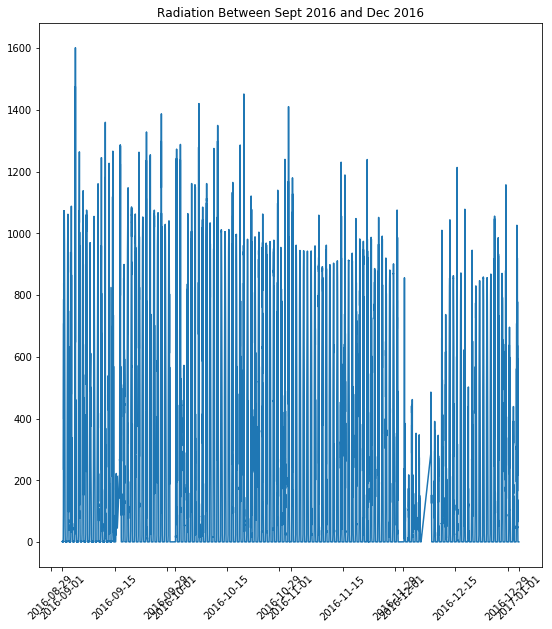

In [ ]:
# show data to predict
plt.rcParams['figure.figsize'] = 9, 10
plt.plot(newData['HawaiiDateTime'], newData['Radiation'])
plt.title('Radiation Between Sept 2016 and Dec 2016')
plt.xticks(rotation=45);

From this, the first deduction that I can make is that there is an oscillatory behavior of the radiation levels over time. Another anomaly which stands out is that during the period of November end and mid-December we can observe that the radiation values are odd. We might need to look into that for any null values.

Let's move to a granular level of abstraction and plot the radiation level over 2 weeks of time.

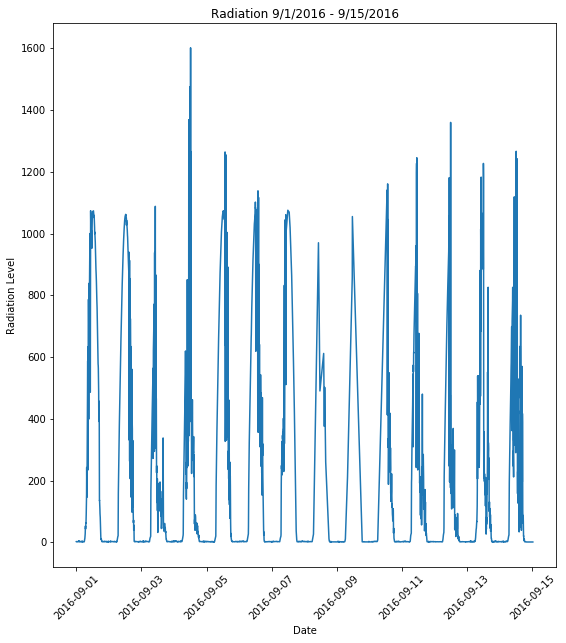

In [ ]:
# Look at a granular level break down of the plotted information
weekendmarker = datetime.datetime(2016,9, 15).replace(tzinfo=HItimeZone)
weekonedata = data[data['HawaiiDateTime'] < weekendmarker]
plt.plot(weekonedata['HawaiiDateTime'], weekonedata['Radiation'])
plt.title('Radiation 9/1/2016 - 9/15/2016')
plt.xticks(rotation=45)
plt.ylabel('Radiation Level')
plt.xlabel('Date');

These plots have been focused solely on solar radiation value. With this, we can understand a little about the radiation data. However, we need to look at the relations between radiation and the other attributes present in the dataset. Plotting the radiation levels along with the other weather attributes separately is as shown below.

In [ ]:
# Custom function to generalise the plotting configuration of all the
# valid features within the dataset
def custom_plot(ax, dates, col, colname):
        
    # apply different colors to differentiate radiation with the remaining
    # attributes
    if colname == 'Radiation':
        plt_color = 'red'
    else:
        plt_color = 'green'
    
    # plot the data
    ax.plot(dates, col, c=plt_color)
    
    # format of graph
    ax.set_title('{colname} 9/1/2016 - 9/15/2016'.format(colname=colname))
    ax.set_ylabel('{colname} Level'.format(colname=colname))
    ax.set_xlabel('Date')
    
    # rotation for labels
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)
    
    return ax

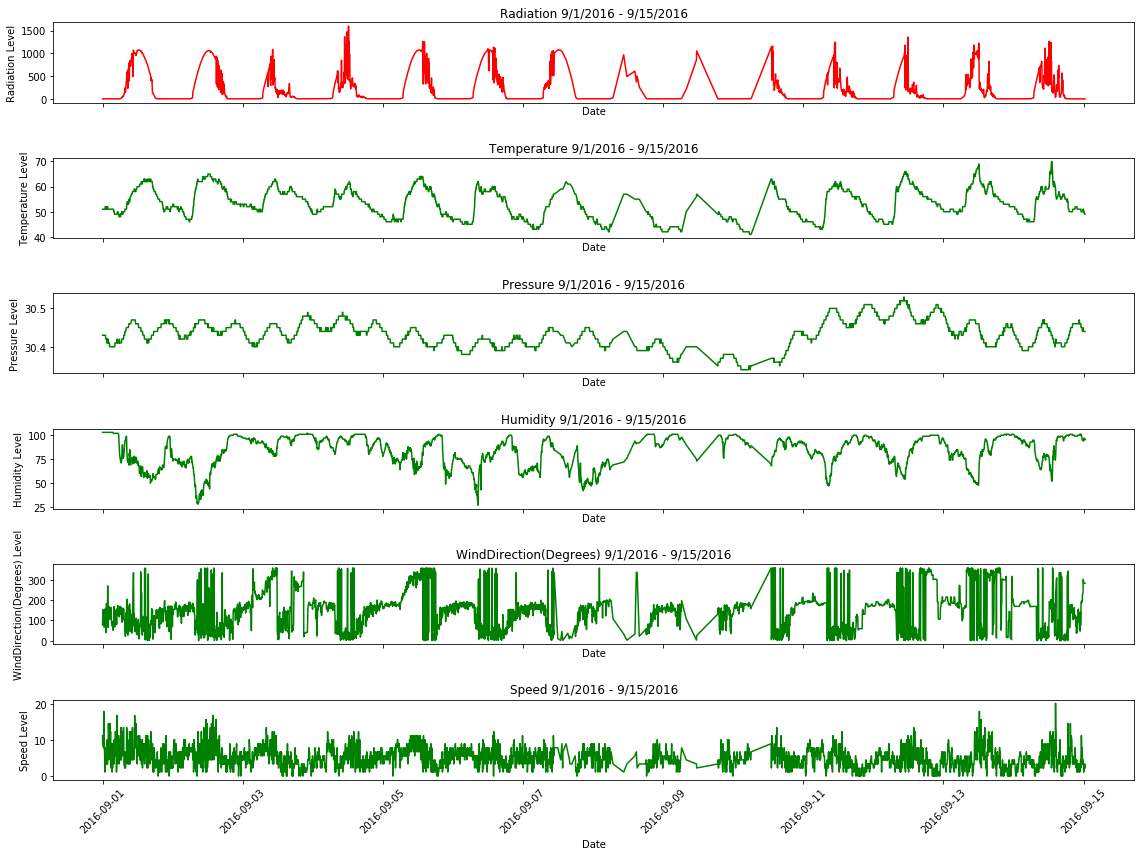

In [ ]:
# make plot larger
plt.rcParams['figure.figsize'] = 16, 12

# loop over all columns important in data
ts_cols = ['Radiation', 'Temperature', 'Pressure', 'Humidity', 
           'WindDirection(Degrees)', 'Speed']
fig, axes = plt.subplots(len(ts_cols), sharex=True)
for i, ax in enumerate(axes):
    ax = custom_plot(ax, weekonedata['HawaiiDateTime'], 
                     weekonedata[ts_cols[i]], 
                     ts_cols[i])

# prevent squashing
fig.tight_layout()

These are some basic plots that display the frequency and trend of various attributes of the dataset. Let's discuss initial findings from the visualization of the dataset features.

# Primary Findings
 
From the above graphs I have found the following key information:

1. In the first graph, the radiation values are behaving oddly during the end of November and mid-December.

2. Looking at the radiation levels spread out for the 2-week duration, an oscillating pattern can be observed.

3. Moreover, within the final plot, one can see that the oscillating pattern of solar radiation is closely matched with that of temperature.

4. Apart from that, Wind direction and speed along with humidity show a high rate of fluctuations.

Finally, as the main focus for this analysis is to identify key features linked to the solar radiation measurements I would think that the following models should be useful in some way.

As the data is not categorical and can not be clustered, the appropriate model should be a regression model:

1. Linear regression
           This is easy to implement and can provide a linear relationship between one dependent (Solar radiation) and other independent variables.
2. ElasticNet or Lasso
           These are regression models which make use of statistical methods to provide better relationship information between various variables.


Moreover, these models should also be useful in identifying key features and discarding less useful features from the analysis.


